In [1]:
"""
For TAs: Set TRUE to run with mini sample 
"""
MINI = True

In [2]:
if MINI:
    crypto_path = './data/crypto/BTC_1sec_MINI.csv'
    crypto_size = 100_000
    fi2010_test_days = [8]  
    fi2010_stocks = [0]
else:
    crypto_path = './data/crypto/BTC_1sec.csv'
    crypto_size = 400_000
    fi2010_test_days = [8,9,10]
    fi2010_stocks = [0,1,2,3,4]

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from utils.fi2010_loader import Dataset_fi2010
from utils.crypto_loader import load_crypto
from models.deep_lob import DeepLOB
from models.trans_lob import TransLOB
from models.deep_trans_lob import DeepTransLOB

%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
BATCH_SIZE = 128
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 20
LABEL_ALPHA = 5e-5

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

normalization = "DecPre"
test_ratio = 0.3
mode = False

normalizations = ["Zscore", "DecPre", "MinMax"]
model_names = ["DeepLOB", "TransLOB", "DeepTransLOB"]
horizons = [0, 1, 2, 3, 4]
dataset_type = "fi2010"

In [6]:
# Dummy mapping from model name to constructor
def get_model_class(name):
    if name == "DeepLOB":
        return DeepLOB
    elif name == "TransLOB":
        return TransLOB
    elif name == "DeepTransLOB":
        return DeepTransLOB
    else:
        raise ValueError("Unknown model name")

def create_test_loader(model_name, normalization):
    stock = [0, 1, 2, 3, 4]
    T = 100
    unsqueeze = model_name=="DeepLOB"
    dataset_test = Dataset_fi2010(False, normalization, fi2010_stocks, fi2010_test_days, WINDOW_SIZE, 4, unsqueeze, False)
    return DataLoader(dataset=dataset_test, batch_size=128, shuffle=False, num_workers=4)

def evaluate_model(model_class, model_name, data_type, normalization, test_loader):
    path = f"./outputs/{data_type}/{model_name}_{normalization}.pth"
    # print(path)
    if not os.path.exists(path):
        print(f"Model not found: {path}, skipping...")
        return {
            "accuracy": np.nan,
            "f1": np.nan,
            "precision": np.nan,
            "recall": np.nan
        }
    model = model_class()
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()

    all_y_true, all_y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # print(X_batch.shape)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_y_true.append(y_batch.cpu().numpy())
            all_y_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
    }

# Crypto Result

In [7]:
results_crypto = []
data_type = "crypto"
for model_name in model_names:
    mode = model_name == "DeepLOB"
    for normalization in normalizations:
        print(f"Evaluating {model_name} | {normalization}")
        train_dataset, test_dataset = load_crypto(crypto_path, LEVELS, HORIZONS, TARGET_HORIZON, LABEL_ALPHA, 
                                     normalization, test_ratio, crypto_size, WINDOW_SIZE, mode, False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        model_class = get_model_class(model_name)
        metrics = evaluate_model(model_class, model_name, data_type, normalization, test_loader)

        results_crypto.append({
            "model": model_name,
            "normalization": normalization,
            **metrics
        })
        
results_crypto = pd.DataFrame(results_crypto)
results_crypto

Evaluating DeepLOB | Zscore
Evaluating DeepLOB | DecPre
Evaluating DeepLOB | MinMax
Evaluating TransLOB | Zscore
Evaluating TransLOB | DecPre
Evaluating TransLOB | MinMax
Evaluating DeepTransLOB | Zscore
Model not found: ./outputs/crypto/DeepTransLOB_Zscore.pth, skipping...
Evaluating DeepTransLOB | DecPre
Evaluating DeepTransLOB | MinMax
Model not found: ./outputs/crypto/DeepTransLOB_MinMax.pth, skipping...


,model,normalization,accuracy,f1,precision,recall
0,DeepLOB,Zscore,0.549000,0.515449,0.525209,0.516779
1,DeepLOB,DecPre,0.832567,0.813441,0.829748,0.805908
2,DeepLOB,MinMax,0.412700,0.375595,0.382782,0.380405
3,TransLOB,Zscore,0.438567,0.381418,0.413138,0.394626
4,TransLOB,DecPre,0.554333,0.512836,0.565161,0.512721
5,TransLOB,MinMax,0.436767,0.371936,0.394214,0.391593
6,DeepTransLOB,Zscore,NaN,NaN,NaN,NaN
7,DeepTransLOB,DecPre,0.773233,0.761493,0.764068,0.770461
8,DeepTransLOB,MinMax,NaN,NaN,NaN,NaN


Skipped missing: ./outputs/crypto/TransLOB_MinMax.pkl
Skipped missing: ./outputs/crypto/DeepTransLOB_Zscore.pkl
Skipped missing: ./outputs/crypto/DeepTransLOB_MinMax.pkl


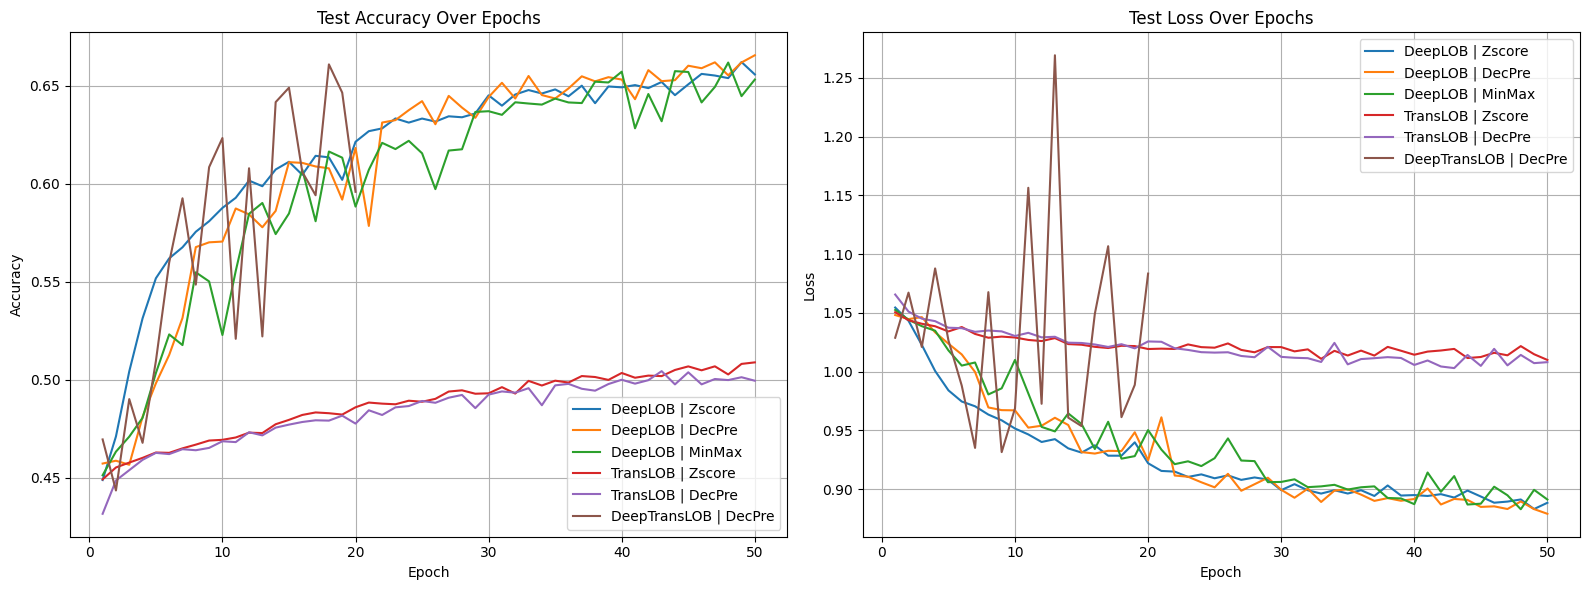

In [8]:
dataset_type = "crypto"
output_dir = f"./outputs/{dataset_type}"

fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
for model_name in model_names:
    for normalization in normalizations:
        pkl_path = os.path.join(output_dir, f"{model_name}_{normalization}.pkl")
        if not os.path.exists(pkl_path):
            print(f"Skipped missing: {pkl_path}")
            continue
        
        with open(pkl_path, "rb") as f:
            history = pickle.load(f)

        label = f"{model_name} | {normalization}"
        epochs = range(1, len(history['train_acc']) + 1)

        ax_acc.plot(epochs, history['val_acc'], linestyle='-', label=f"{label}")#, color=color)

        ax_loss.plot(epochs, history['val_loss'], linestyle='-', label=f"{label}")#, color=color)

ax_acc.set_title("Test Accuracy Over Epochs")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.grid(True)
ax_acc.legend()

ax_loss.set_title("Test Loss Over Epochs")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.grid(True)
ax_loss.legend()

plt.tight_layout()
plt.show()


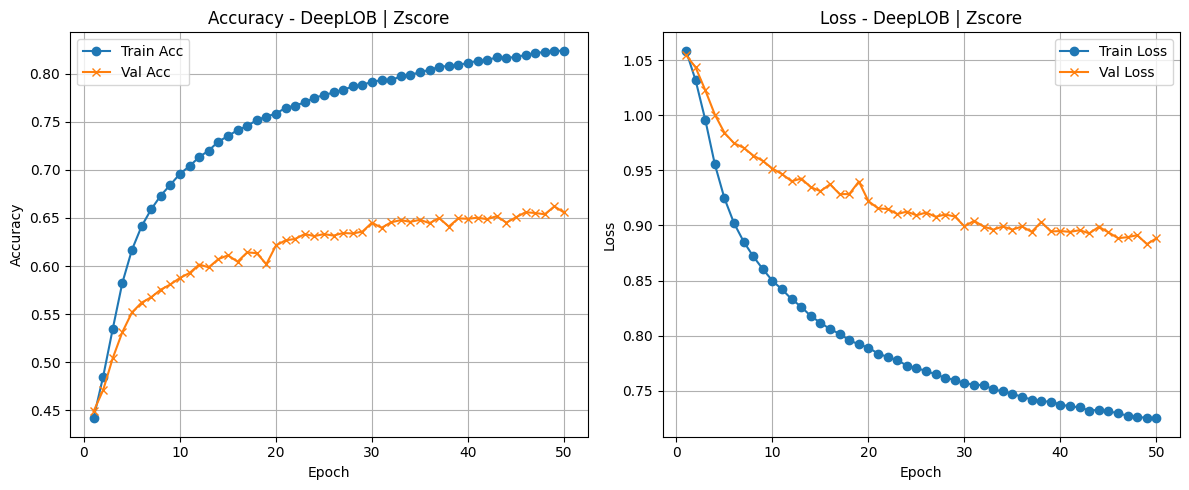

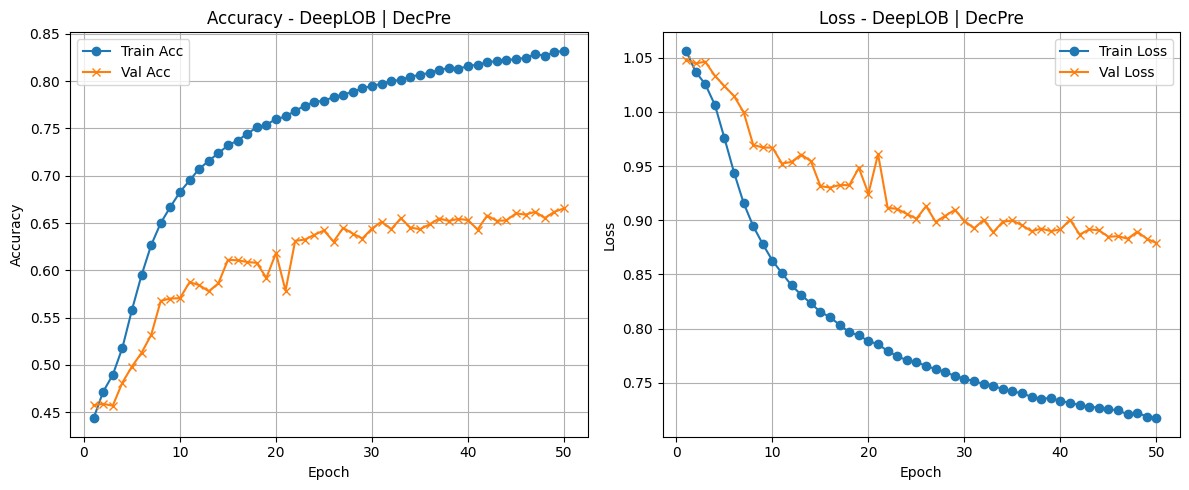

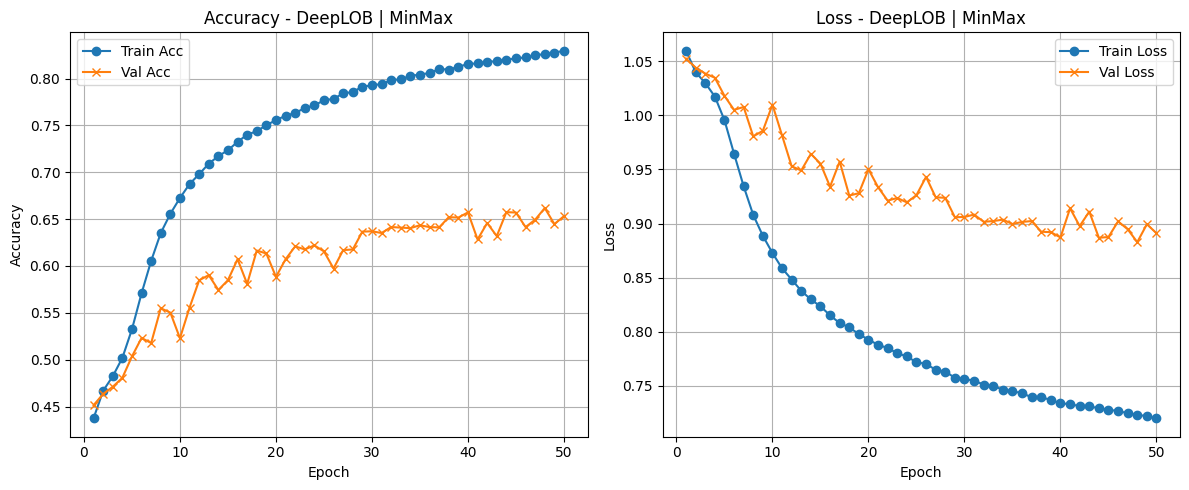

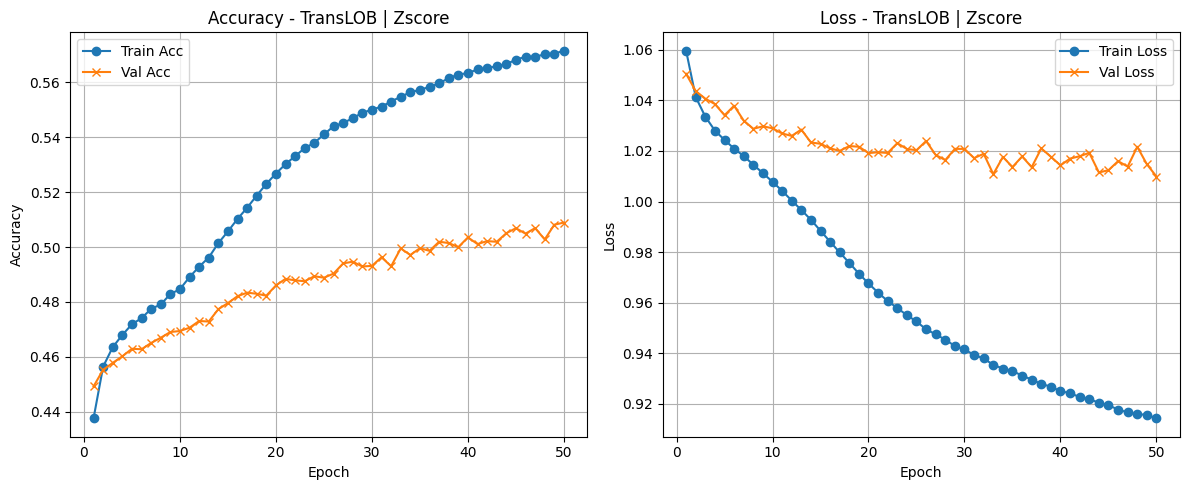

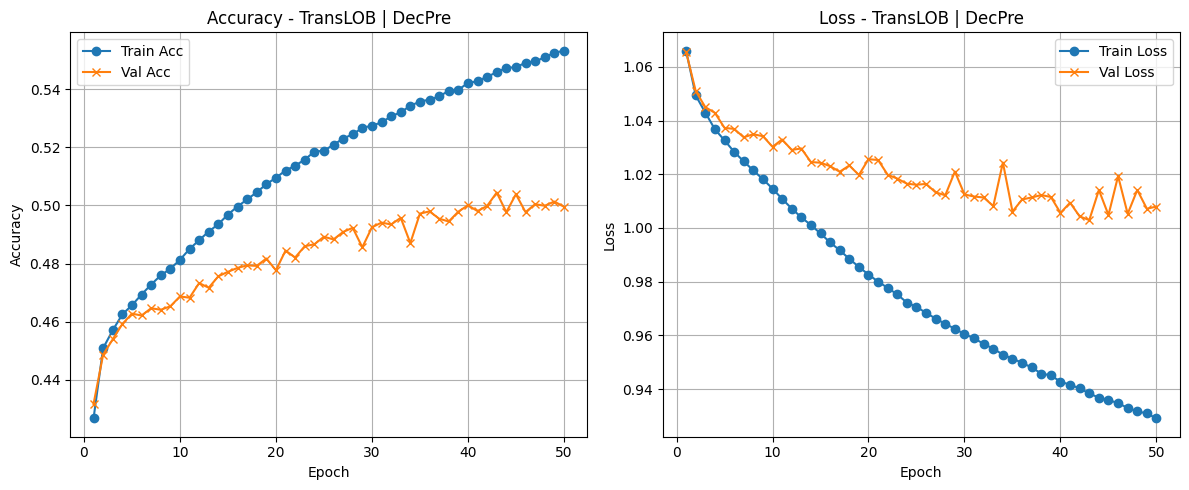

Skipped missing: ./outputs/crypto/TransLOB_MinMax.pkl
Skipped missing: ./outputs/crypto/DeepTransLOB_Zscore.pkl


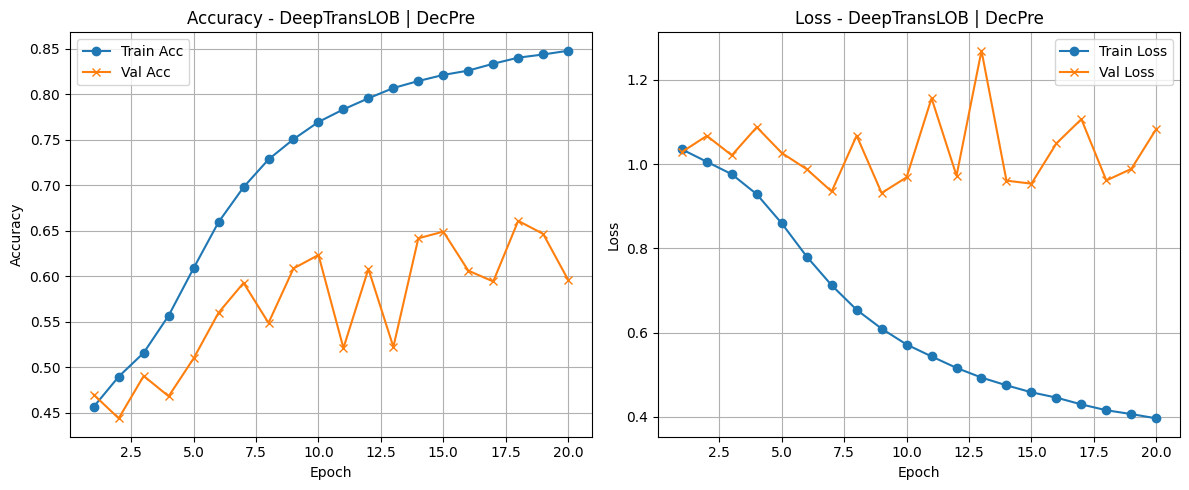

Skipped missing: ./outputs/crypto/DeepTransLOB_MinMax.pkl


In [9]:
dataset_type = "crypto"
output_dir = f"./outputs/{dataset_type}"

for model_name in model_names:
    for normalization in normalizations:
        pkl_path = os.path.join(output_dir, f"{model_name}_{normalization}.pkl")
        
        if not os.path.exists(pkl_path):
            print(f"Skipped missing: {pkl_path}")
            continue
        
        with open(pkl_path, "rb") as f:
            history = pickle.load(f)

        epochs = range(1, len(history['train_acc']) + 1)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].plot(epochs, history['train_acc'], label="Train Acc", marker='o')
        axs[0].plot(epochs, history['val_acc'], label="Val Acc", marker='x')
        axs[0].set_title(f"Accuracy - {model_name} | {normalization}")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(epochs, history['train_loss'], label="Train Loss", marker='o')
        axs[1].plot(epochs, history['val_loss'], label="Val Loss", marker='x')
        axs[1].set_title(f"Loss - {model_name} | {normalization}")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

# FI-2010 Results

In [10]:
data_type = "fi2010"

results_fi2010 = []
for model_name in model_names:
    for normalization in normalizations:
        print(f"Evaluating {model_name} | {normalization}")
        test_loader = create_test_loader(model_name, normalization)
        model_class = get_model_class(model_name)
        metrics = evaluate_model(model_class, model_name, data_type, normalization, test_loader)

        results_fi2010.append({
            "model": model_name,
            "normalization": normalization,
            **metrics
        })

results_fi2010 = pd.DataFrame(results_fi2010)
results_fi2010

Evaluating DeepLOB | Zscore
Evaluating DeepLOB | DecPre
Evaluating DeepLOB | MinMax
Evaluating TransLOB | Zscore
Evaluating TransLOB | DecPre
Evaluating TransLOB | MinMax
Evaluating DeepTransLOB | Zscore
Model not found: ./outputs/fi2010/DeepTransLOB_Zscore.pth, skipping...
Evaluating DeepTransLOB | DecPre
Evaluating DeepTransLOB | MinMax
Model not found: ./outputs/fi2010/DeepTransLOB_MinMax.pth, skipping...


,model,normalization,accuracy,f1,precision,recall
0,DeepLOB,Zscore,0.617739,0.478867,0.607897,0.468248
1,DeepLOB,DecPre,0.621664,0.514811,0.604693,0.505043
2,DeepLOB,MinMax,0.651884,0.546775,0.596653,0.529370
3,TransLOB,Zscore,0.589482,0.495838,0.548099,0.487933
4,TransLOB,DecPre,0.565149,0.446572,0.505539,0.432498
5,TransLOB,MinMax,0.799451,0.571448,0.630267,0.576936
6,DeepTransLOB,Zscore,NaN,NaN,NaN,NaN
7,DeepTransLOB,DecPre,0.656986,0.562916,0.598215,0.554452
8,DeepTransLOB,MinMax,NaN,NaN,NaN,NaN


Skipped missing: ./outputs/fi2010/DeepLOB_Zscore.pkl
Skipped missing: ./outputs/fi2010/DeepLOB_DecPre.pkl
Skipped missing: ./outputs/fi2010/DeepLOB_MinMax.pkl
Skipped missing: ./outputs/fi2010/DeepTransLOB_Zscore.pkl
Skipped missing: ./outputs/fi2010/DeepTransLOB_MinMax.pkl


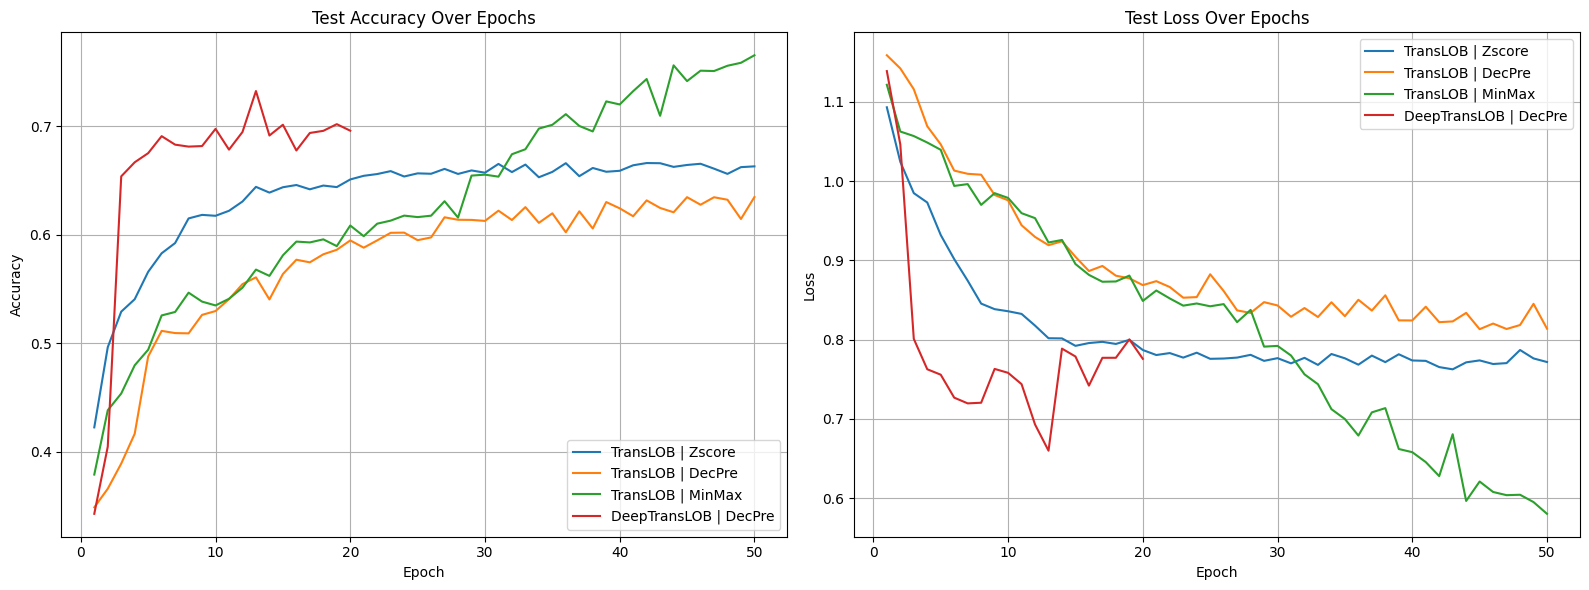

In [11]:
dataset_type = "fi2010"
output_dir = f"./outputs/{dataset_type}"

fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
for model_name in model_names:
    for normalization in normalizations:
        pkl_path = os.path.join(output_dir, f"{model_name}_{normalization}.pkl")
        if not os.path.exists(pkl_path):
            print(f"Skipped missing: {pkl_path}")
            continue
        
        with open(pkl_path, "rb") as f:
            history = pickle.load(f)

        label = f"{model_name} | {normalization}"
        epochs = range(1, len(history['train_acc']) + 1)

        ax_acc.plot(epochs, history['val_acc'], linestyle='-', label=f"{label}")#, color=color)

        ax_loss.plot(epochs, history['val_loss'], linestyle='-', label=f"{label}")#, color=color)

ax_acc.set_title("Test Accuracy Over Epochs")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.grid(True)
ax_acc.legend()

ax_loss.set_title("Test Loss Over Epochs")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.grid(True)
ax_loss.legend()

plt.tight_layout()
plt.show()
